# Convolutional Autoencoder

Reflections:
In the following model, I will attempt to use the k_resize_images and the nearest neighbor approach to upsample (i.e. deconvolve images) to try to auto-encode the full blown color images.

FootNote:
Rescaling the color images' pixels with the mean and std causes significant distortion in the images' colors (even in the training set). Thus, the generated images really have no meaningful color representations. The quality seems to be slightly better than those for grayscale images though.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
inputs_ = tf.placeholder(tf.float32, (None, 224, 224, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 224, 224, 3), name='targets')

In [3]:
xavier_wts = tf.contrib.layers.xavier_initializer()
alpha = 0.5

In [4]:
def getEncoder(images, is_training = True, reuse=False):
    ### Encoder  
    with tf.variable_scope("encoder",reuse=reuse):

        # input: 224 * 224 * num_channels    
        x = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)

        #print(x.shape.as_list())

        # input: 112 * 112 * _   
        x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # input: 56 * 56 * _
        x = tf.layers.conv2d(inputs=x, filters=128, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # input: 28 * 28 * _
        x = tf.layers.conv2d(inputs=x, filters=256, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # input: 14 * 14 * _
        x = tf.layers.conv2d(inputs=x, filters=512, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # Output: 7 * 7 * _
        return x

In [5]:
enc_output = getEncoder(inputs_)

In [6]:
print(enc_output.shape)

(?, 7, 7, 512)


In [7]:
def getDecoder(encoder_input, is_training=True, reuse=False):
    with tf.variable_scope("decoder", reuse=reuse):
        
        # input: 7 * 7 * _
        x1 = tf.image.resize_nearest_neighbor(encoder_input, (14, 14))

        x2 = tf.layers.conv2d(inputs=x1, filters=256, activation=None, kernel_size=5, strides=1, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training)
        x2 = tf.maximum(alpha * x2, x2)

        # input: 14 * 14 * _ 
        x3 = tf.image.resize_nearest_neighbor(x2, (28, 28))
        x3 = tf.layers.conv2d(inputs=x3, filters=128, activation=None, kernel_size=5, strides=1, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)        

        # input: 28 * 28 * _ 
        x4 = tf.image.resize_nearest_neighbor(x3, (56, 56))
        x4 = tf.layers.conv2d(inputs=x4, filters=64, activation=None, kernel_size=5, strides=1, padding='same', kernel_initializer=xavier_wts, use_bias=False)
        x4 = tf.layers.batch_normalization(inputs=x4, training=is_training)
        x4 = tf.maximum(alpha * x4, x4)        

        # input: 56 * 56 * _ 
        x5 = tf.image.resize_nearest_neighbor(x4, (112, 112))
        x5 = tf.layers.conv2d(inputs=x5, filters=32, activation=None, kernel_size=5, strides=1, padding='same', kernel_initializer=xavier_wts, use_bias=False )
        x5 = tf.layers.batch_normalization(inputs=x5, training=is_training)
        x5 = tf.maximum(alpha * x5, x5)        

        # input: 112 * 112 * _
        x5 = tf.image.resize_nearest_neighbor(x4, (224, 224))
        x5 = tf.layers.conv2d(inputs=x5, filters=3, activation=None, kernel_size=5, strides=1, padding='same', kernel_initializer=xavier_wts, use_bias=False)

        # rescale output using tanh
        decoder_output = tf.tanh(x5)
        return decoder_output

In [8]:
dec_output = getDecoder(enc_output)

In [9]:
print(dec_output.shape.as_list())

[None, 224, 224, 3]


## Define model loss and optimizer

In [10]:
loss = tf.reduce_mean(tf.squared_difference(targets_, dec_output))

In [11]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

## Ingest Images

In [12]:
all_images = np.load('Product_Images/all_images_raw_color.npy')
mean_imgs = np.mean(all_images)
stddev = np.std(all_images)

# rescale image so that pixels dont have the range from 0 - 255
rescaled_images = (all_images - mean_imgs)/stddev

# reshape images so that it can be fed to con2d methods
in_images = np.reshape(rescaled_images, newshape=(-1,224,224,3))

In [13]:
def image_generator(images, batch_size):
    start_index = 0    
    while start_index < len(images):
        end_index = start_index + batch_size
        yield images[start_index:end_index,:,:,:]
        start_index = end_index

batch_size = 128

In [20]:
np.random.shuffle(in_images)

In [21]:
print(in_images.shape)

(4999, 224, 224, 3)


In [22]:
train_images = in_images[0:4000]
valid_images = in_images[4000:4999]

In [23]:
print(train_images.shape)
print(valid_images.shape)

(4000, 224, 224, 3)
(999, 224, 224, 3)


In [25]:
np.save("color_train_images_set.npy",train_images)
np.save("color_valid_images_set.npy",valid_images)

## Training Code

In [32]:
saver = tf.train.Saver()

In [26]:
train_count = 0
def eval_train_loss(loss, returnSum):
    if(train_count == 0):
        cum_train_loss = 0.
    train_count +=1
    cum_train_loss += loss

In [27]:
valid_count = 0
def eval_valid_loss(loss, returnSum):
    if(valid_count == 0):
        cum_valid_loss = 0.
    valid_count +=1
    cum_valid_loss += loss

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [34]:
start_epochs = 0
end_epochs = 40

In [ ]:
for epoch_n in range(start_epochs, end_epochs):
    print("starting epoch: "+str(epoch_n))
    counter = 0
    
    for img in image_generator(train_images, batch_size):
        counter +=1
        
        _ , train_loss = sess.run([opt, loss], feed_dict={inputs_:img, targets_:img})        

        if(counter%10==0):
            print("  train_loss: "+str(train_loss))
            
    # validation at the end of an epoch. For now, take only a subset of the total validation set.    
    valid_loss = sess.run(loss, feed_dict={inputs_:valid_images[0:256], targets_:valid_images[0:256]})
        
    print("  valid loss: ", str(valid_loss))

In [33]:
saver.save(sess, "./saved_models/color_model")

'./saved_models/color_model'

## Print some images for visual validation

### Trained images

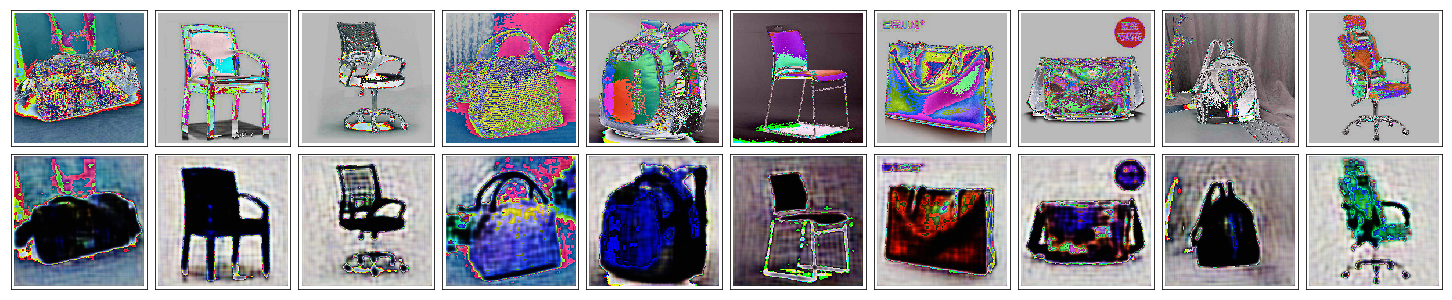

In [30]:
show_imgs = train_images[50:60]

# draw the image
# make plots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

reconstructed = sess.run(dec_output, feed_dict={inputs_: show_imgs})
for images, row in zip([show_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((224, 224,3)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

### Validation images

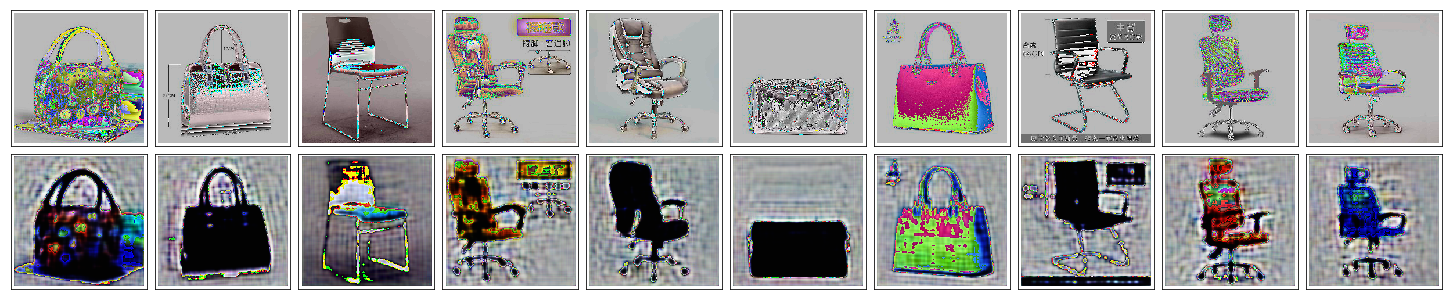

In [31]:
show_imgs = valid_images[20:30]

# draw the image
# make plots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

reconstructed = sess.run(dec_output, feed_dict={inputs_: show_imgs})
for images, row in zip([show_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((224, 224,3)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)